In [1]:
pip install youtube-transcript-api

**Transcript Retrieval and CSV Export**

The provided Python script retrieves the transcript of a YouTube video along with its title and saves this information to a CSV file. It starts by importing necessary libraries such as re for regular expressions, csv for handling CSV files, and pandas for data manipulation. The script uses the Google YouTube Data API to fetch video details and the YouTube Transcript API to obtain the video's transcript.

The get_video_id function extracts the video ID from a provided YouTube URL. Next, get_video_title retrieves the video's title using the YouTube API, while get_video_transcript attempts to fetch the transcript; it handles any potential errors gracefully. The save_to_csv function organizes the transcript data and appends the video's title to a CSV file. Finally, the main function orchestrates the process by prompting the user for a YouTube link, validating it, and executing the other functions accordingly, ultimately saving the transcript in a file named after the video ID.


In [2]:
import re
import csv
import pandas as pd
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi

API_KEY = 'f{enter your API_KEY}'

def get_video_id(url):
    video_id_match = re.search(r'(?:v=|\/)([0-9A-Za-z_-]{11}).*', url)
    return video_id_match.group(1) if video_id_match else None

def get_video_title(video_id):
    youtube = build('youtube', 'v3', developerKey=API_KEY)

    request = youtube.videos().list(
        part='snippet',
        id=video_id
    )
    response = request.execute()

    title = response['items'][0]['snippet']['title'] if response['items'] else 'Unknown Title'
    return title

def get_video_transcript(video_id):
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return transcript
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

def save_to_csv(title, transcript, filename):
    transcript_data = [{'start': entry['start'], 'text': entry['text']} for entry in transcript]
    df = pd.DataFrame(transcript_data)
    df.to_csv(filename, index=False)

    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Title:', title])

def main():
    url = input('Enter the YouTube video link: ')
    video_id = get_video_id(url)

    if not video_id:
        print('Invalid YouTube URL.')
        return

    title = get_video_title(video_id)
    transcript = get_video_transcript(video_id)

    if not transcript:
        print('No transcript available for this video.')
        return

    filename = f"{video_id}_transcript.csv"
    save_to_csv(title, transcript, filename)
    print(f'Transcript saved to {filename}')

if __name__ == '__main__':
    main()

Enter the YouTube video link: https://www.youtube.com/watch?v=4QkYy1wANXA&list=PLeo1K3hjS3utcb9nKtanhcn8jd2E0Hp9b&index=2
Transcript saved to 4QkYy1wANXA_transcript.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

transcript_df = pd.read_csv("/content/4QkYy1wANXA_transcript.csv")
print(transcript_df.head())

   start                                      text
0    0.0   T20 Cricket World Cup was finished just
1  2.399      few weeks back with England claiming
2    4.2   victory over Pakistan, and today we are
3   6.54        beginning a cricket data analytics
4   8.58  series using same T20 World Cup data. We


In [4]:
transcript_df['start'] = pd.to_numeric(transcript_df['start'], errors='coerce')

print("Dataset Overview:")
print(transcript_df.info())
print("\nBasic Statistics:")
print(transcript_df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254 entries, 0 to 2253
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   start   2253 non-null   float64
 1   text    2254 non-null   object 
dtypes: float64(1), object(1)
memory usage: 35.3+ KB
None

Basic Statistics:
             start
count  2253.000000
mean   3055.164951
std    1770.803917
min       0.000000
25%    1482.900000
50%    3073.200000
75%    4624.440000
max    6007.910000


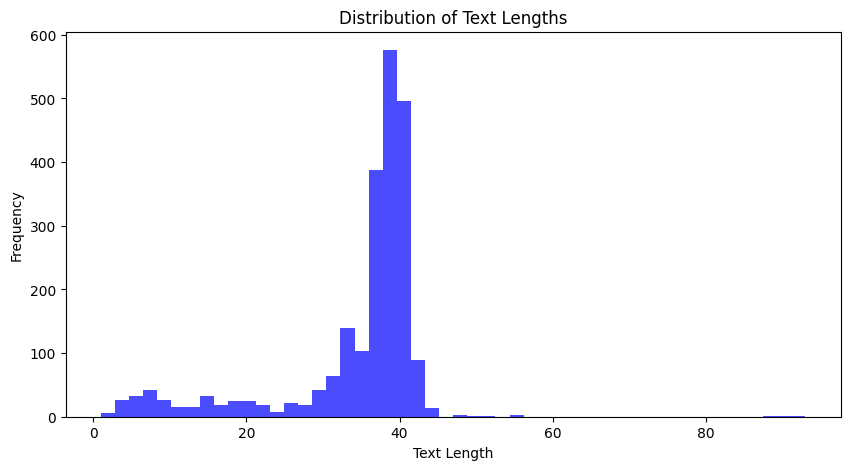

In [5]:
transcript_df['text_length'] = transcript_df['text'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(transcript_df['text_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

**Word Frequency Analysis and Visualization of Transcript Data**

This code snippet analyzes the frequency of words in a transcript stored in a DataFrame and visualizes the most common words using a bar chart. It utilizes CountVectorizer to convert the text data into a matrix of word counts while excluding common English stop words. The word counts are summed and sorted to identify the top 20 most frequent words. Finally, a bar chart is generated using matplotlib to display these common words along with their frequencies, providing insights into the key themes or topics in the transcript.

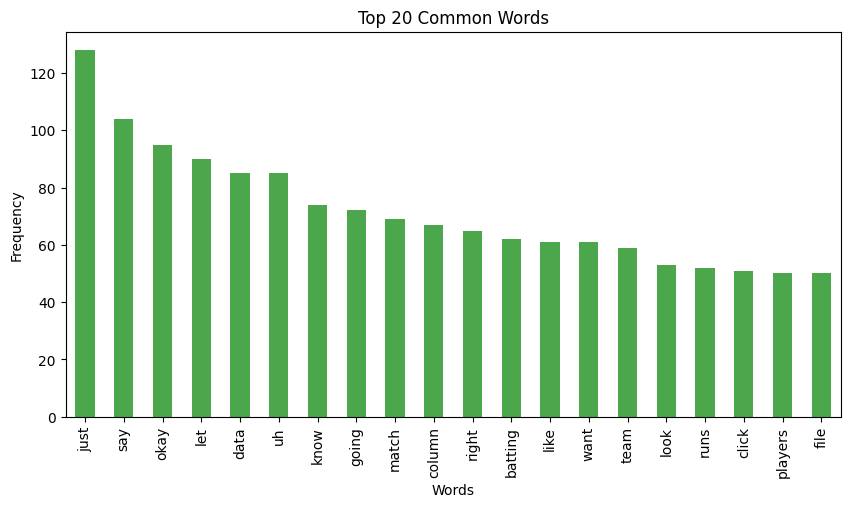

In [6]:
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(transcript_df['text'])
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
common_words = word_counts_df.sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 5))
common_words.plot(kind='bar', color='green', alpha=0.7)
plt.title('Top 20 Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

**Topic Modeling of Transcript Data Using Non-negative Matrix Factorization (NMF)**

This code snippet performs topic modeling on a transcript dataset using Non-negative Matrix Factorization (NMF). It starts by defining parameters such as the number of features, topics, and top words to extract. The CountVectorizer is used to transform the text into a term-frequency matrix while filtering out common stop words. NMF is then applied to this matrix to identify the specified number of topics.

The display_topics function extracts and displays the top words associated with each identified topic by sorting the components of the NMF model. Finally, the topics are printed, showcasing the key themes present in the transcript data. This approach helps uncover underlying patterns and subjects within the text, making it easier to analyze and interpret the content.

In [7]:
n_features = 1000
n_topics = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(transcript_df['text'])
nmf = NMF(n_components=n_topics, random_state=42).fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(" ".join(topic_words))
    return topics

topics = display_topics(nmf, tf_feature_names, n_top_words)
print("\nIdentified Topics:")
for i, topic in enumerate(topics):
    print(f"Topic {i + 1}: {topic}")


Identified Topics:
Topic 1: say let right click ll particular boundary look print code
Topic 2: just know say ll drop number want don run downloads
Topic 3: uh know good ll look power bowling different performance click
Topic 4: okay like file key use ll total csv measures innings
Topic 5: data power bright bi transformation analytics cricket collection look project
Topic 6: batting match summary average file id fact results element json
Topic 7: strike rate bowling runs average ball greater 140 want total
Topic 8: column create new want called dismissal right balls particular match
Topic 9: team vs right need like sri lanka 11 click overs
Topic 10: going use players files select want code file csv create


In [8]:
topic_distribution = nmf.transform(tf)

topic_distribution_trimmed = topic_distribution[:len(transcript_df)]

transcript_df['dominant_topic'] = topic_distribution_trimmed.argmax(axis=1)

In [9]:
logical_breaks = []

for i in range(1, len(transcript_df)):
    if transcript_df['dominant_topic'].iloc[i] != transcript_df['dominant_topic'].iloc[i - 1]:
        logical_breaks.append(transcript_df['start'].iloc[i])

In [10]:
threshold = 60
consolidated_breaks = []
last_break = None

for break_point in logical_breaks:
    if last_break is None or break_point - last_break >= threshold:
        consolidated_breaks.append(break_point)
        last_break = break_point

In [11]:
final_chapters = []
last_chapter = (consolidated_breaks[0], transcript_df['dominant_topic'][0])

for break_point in consolidated_breaks[1:]:
    current_topic = transcript_df[transcript_df['start'] == break_point]['dominant_topic'].values[0]
    if current_topic == last_chapter[1]:
        last_chapter = (last_chapter[0], current_topic)
    else:
        final_chapters.append(last_chapter)
        last_chapter = (break_point, current_topic)

final_chapters.append(last_chapter)

**Generation of Readable Chapter Points and Titles from Transcript Data**

This code snippet processes a transcript to create chapter points and corresponding names in a readable format. It converts each chapter's time from seconds to HH:MM:SS and extracts relevant text based on chapter break points and dominant topics. To generate descriptive chapter names, it uses TfidfVectorizer to identify significant key phrases while filtering out common stop words. These phrases are combined to form concise titles for each chapter. Finally, the chapter times and names are printed, enhancing the readability and navigability of the transcript, making it easier for users to locate specific sections.

In [12]:
chapter_points = []
chapter_names = []

for i, (break_point, topic_idx) in enumerate(final_chapters):
    chapter_time = pd.to_datetime(break_point, unit='s').strftime('%H:%M:%S')
    chapter_points.append(chapter_time)


    chapter_text = transcript_df[(transcript_df['start'] >= break_point) & (transcript_df['dominant_topic'] == topic_idx)]['text'].str.cat(sep=' ')


    vectorizer = TfidfVectorizer(stop_words='english', max_features=3)
    tfidf_matrix = vectorizer.fit_transform([chapter_text])
    feature_names = vectorizer.get_feature_names_out()
    chapter_name = " ".join(feature_names)

    chapter_names.append(f"Chapter {i+1}: {chapter_name}")


print("\nFinal Chapter Points with Names:")
for time, name in zip(chapter_points, chapter_names):
    print(f"{time} - {name}")


Final Chapter Points with Names:
00:00:02 - Chapter 1: just number say
00:01:04 - Chapter 2: like right team
00:02:05 - Chapter 3: data look power
00:03:06 - Chapter 4: basically file okay
00:04:12 - Chapter 5: need right team
00:05:12 - Chapter 6: different know uh
00:07:12 - Chapter 7: files going players
00:08:17 - Chapter 8: need right team
00:09:54 - Chapter 9: just number say
00:10:58 - Chapter 10: code going players
00:11:59 - Chapter 11: let row say
00:13:00 - Chapter 12: column create want
00:14:07 - Chapter 13: batting match summary
00:15:08 - Chapter 14: data look power
00:16:11 - Chapter 15: files going players
00:17:12 - Chapter 16: column create want
00:18:14 - Chapter 17: file measures okay
00:19:15 - Chapter 18: files going players
00:20:15 - Chapter 19: data look power
00:21:16 - Chapter 20: just number say
00:22:25 - Chapter 21: like right team
00:24:29 - Chapter 22: column create want
00:25:31 - Chapter 23: data look power
00:27:36 - Chapter 24: file measures okay
0